In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4 * x + 5

In [3]:
def derivate_f(x):
  return 6 * x - 4

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)

In [6]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [7]:
ys = f(xs)

In [8]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

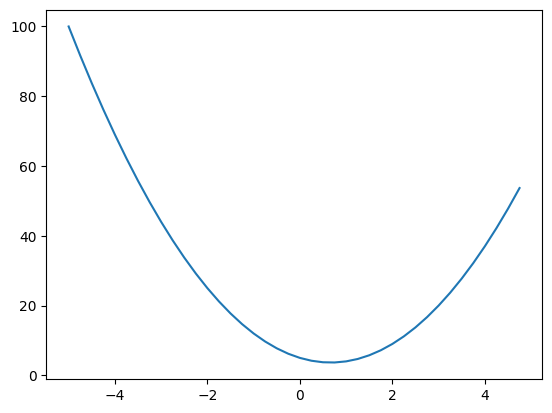

In [9]:
plt.plot(xs, ys)

In [10]:
# La derivada es Lim h->0 (f(x + h) - f(x))/h
# Si hacemos h más chico nos acercamos más al número real
h = 0.000001
x = 3.0
(f(x + h) - f(x))/h

14.000003002223593

In [11]:
derivate_f(3.0)

14.0

In [12]:
#lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [13]:
# lets find the derivate of d respect a,b,c
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
#a += h
#b += h
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [14]:
class Value:

  def __init__(self, data, _children=(), _op = '', label = ''):
    self.data = data
    self.grad = 0
    self._backward = lambda:None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data = {self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other


  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    out = self * other**-1
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x ) - 1) / (math.exp(2*x) + 1)
    out = Value(t,(self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    #topo
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data = -8.0)

In [15]:
d

Value(data = 4.0)

In [16]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [17]:
a.__add__(b)

Value(data = -1.0)

In [18]:
(a.__mul__(b)).__add__(c)

Value(data = 4.0)

In [19]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [20]:
def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape = 'record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

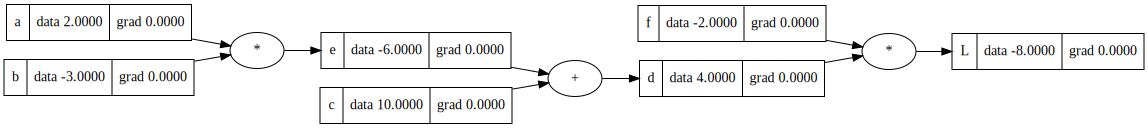

In [21]:
draw_dot(L)

In [22]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-8.0


In [23]:
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0
e.grad = -2.0

dL / de = -2.0
e = a * b
de / da?

dl / da = (dL / de) * (de / da)

In [24]:
c.grad = -2.0
d.grad = -2.0

dd / dc = 1.0
dd / de = 1.0
d = c + e

WANT:
dl / dc = ( dL / dd) * ( dd / dc)
# Como la derivada en una suma es 1

KNOW:
dL / dd
dd / dc

L = d * f
# dL/dd = ? f
(f(x+h) - f(x) / h)

((d+h) * f - d*f) / h
((d*f) + (f*h) - d*f) / h
f*h/h
f

In [25]:
L.grad = 1.0

In [26]:
f.grad = 4.0
d.grad = -2.0

In [27]:
def lol():
  h = 0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0 + h, label = 'f')
  L = d * f; L.label = 'L'
  L2 = L.data + h
  L2
  print((L2 - L1) / h)

lol()

4.999999999999893


In [28]:
#o.backward()

In [29]:
#draw_dot(o)

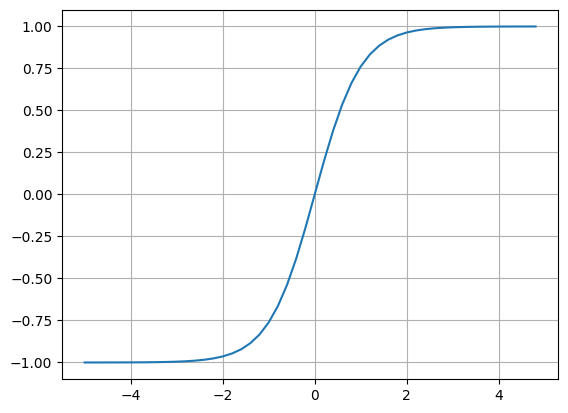

In [30]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [31]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); label = 'o'

In [32]:
o.backward()

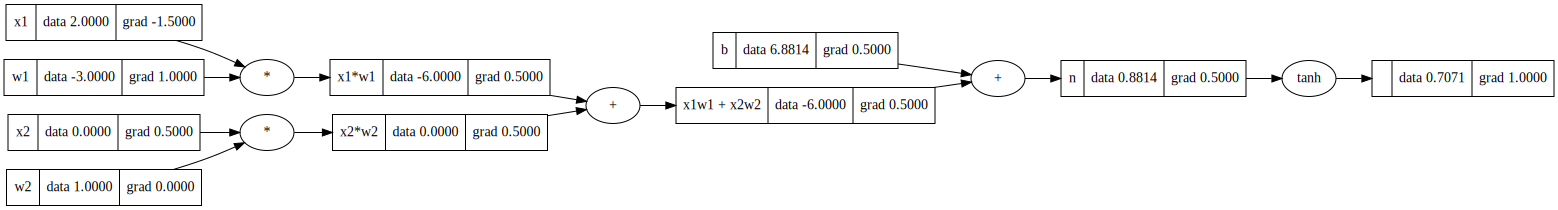

In [33]:
draw_dot(o)

In [34]:
o.grad = 1.0
o._backward()

In [35]:
n._backward()

In [36]:
gad_b = b._backward()
print(gad_b)

None


In [37]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [38]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [39]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [40]:
x1w1x2w2 = 0.5
b.grad = 0.5

In [41]:
o.grad = 1.0

In [42]:
n.grad = 1 - o.data**2

In [43]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
#topo
for node in reversed(topo):
  node._backward()

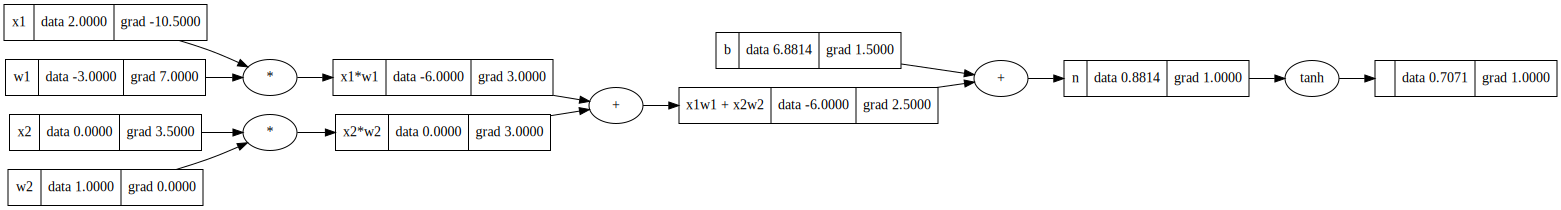

In [44]:
draw_dot(o)

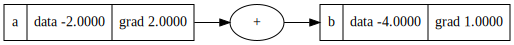

In [45]:
a = Value(-2.0, label = 'a')
b = a + a     ; b.label = 'b'
b.backward()
draw_dot(b)

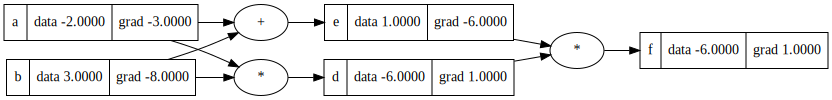

In [46]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)


In [47]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data = 0.5)

In [48]:
# a / b
# a * (1/b)
# a * (b**-1)

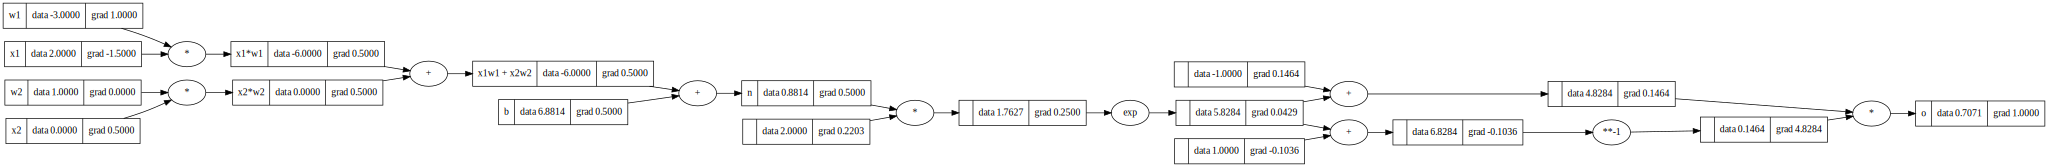

In [49]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [50]:
import random

In [51]:
random.uniform(-1,1)

0.5718147635669368

In [52]:
len(np.random.uniform(-1,1,1000))

1000

In [53]:
import torch

In [54]:
x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data)
print(o.data.item())
o.backward()

print("---------------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


tensor([0.7071], dtype=torch.float64)
0.7071066904050358
---------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [55]:
torch.Tensor([[1,2,4],[5,6,7]]).ndim

2

In [56]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __repr__(self) -> str:
    return f'Pesos neuronas {self.w}'

  def __call__(self, x):
    # w * x + b
    print(list(zip(self.w, x)))
    preact = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    act = preact.tanh()
    return act

  def parameters(self):
    return  self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
    print((self.neurons[0]))

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] +  nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
#n = MLP (3, [1])
n = MLP (3, [4,4,1])
n(x)

Pesos neuronas [Value(data = 0.4325319214981911), Value(data = -0.7031019635430313), Value(data = -0.6224375147415611)]
Pesos neuronas [Value(data = -0.4134132927113301), Value(data = -0.8569754357638009), Value(data = -0.09531347820617264), Value(data = 0.5715467777896575)]
Pesos neuronas [Value(data = 0.31123258559386136), Value(data = 0.8628449641259999), Value(data = 0.34077742365072416), Value(data = 0.4897032513850246)]
[(Value(data = 0.4325319214981911), 2.0), (Value(data = -0.7031019635430313), 3.0), (Value(data = -0.6224375147415611), -1.0)]
[(Value(data = -0.2807257686266591), 2.0), (Value(data = -0.4286039513387996), 3.0), (Value(data = -0.1454643516848726), -1.0)]
[(Value(data = 0.9245242527942512), 2.0), (Value(data = -0.5179158064957026), 3.0), (Value(data = 0.7418192010568068), -1.0)]
[(Value(data = 0.8448018567578921), 2.0), (Value(data = 0.03385691286428072), 3.0), (Value(data = -0.37139474541601425), -1.0)]
[(Value(data = -0.4134132927113301), Value(data = -0.89893204

Value(data = 0.8773152971211455)

[(Value(data = 0.4325319214981911), 2.0), (Value(data = -0.7031019635430313), 3.0), (Value(data = -0.6224375147415611), -1.0)]
[(Value(data = -0.2807257686266591), 2.0), (Value(data = -0.4286039513387996), 3.0), (Value(data = -0.1454643516848726), -1.0)]
[(Value(data = 0.9245242527942512), 2.0), (Value(data = -0.5179158064957026), 3.0), (Value(data = 0.7418192010568068), -1.0)]
[(Value(data = 0.8448018567578921), 2.0), (Value(data = 0.03385691286428072), 3.0), (Value(data = -0.37139474541601425), -1.0)]
[(Value(data = -0.4134132927113301), Value(data = -0.8989320442856922)), (Value(data = -0.8569754357638009), Value(data = -0.8674521481502251)), (Value(data = -0.09531347820617264), Value(data = -0.7014884801698704)), (Value(data = 0.5715467777896575), Value(data = 0.9845323438277268))]
[(Value(data = 0.8593513953217029), Value(data = -0.8989320442856922)), (Value(data = -0.8741151043929507), Value(data = -0.8674521481502251)), (Value(data = 0.2759605263758962), Value(data = -0.70148848

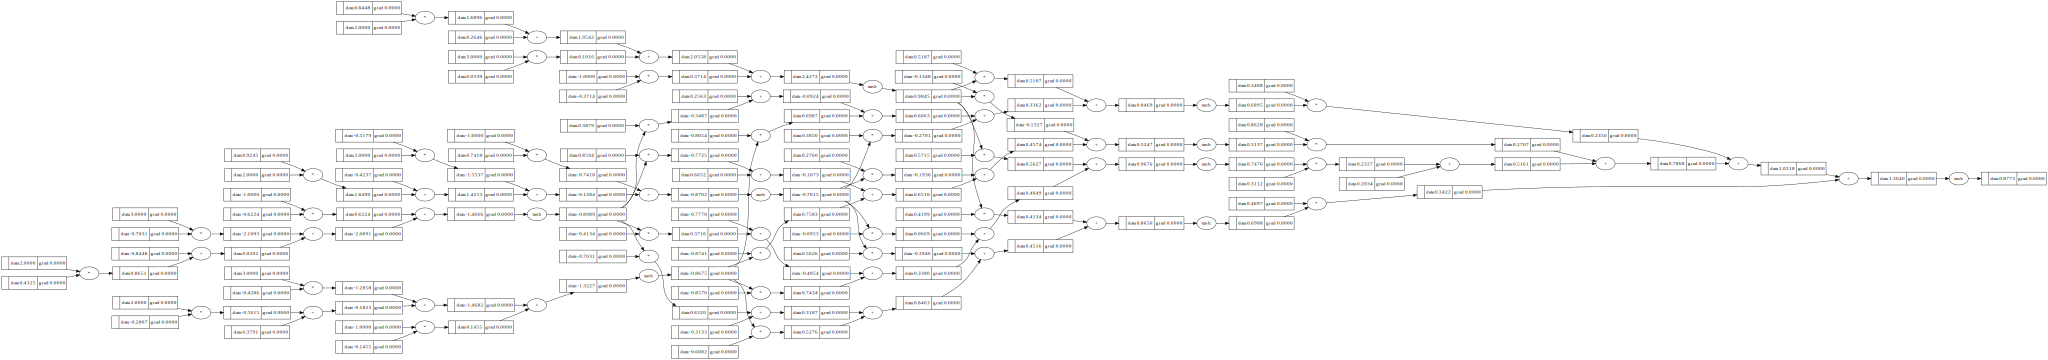

In [57]:
draw_dot(n(x))

In [58]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5,1.0, 1.0],
    [1.0,1.0, -1.0]
]
ys = [1.0, -1.0,-1.0,1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[(Value(data = 0.4325319214981911), 2.0), (Value(data = -0.7031019635430313), 3.0), (Value(data = -0.6224375147415611), -1.0)]
[(Value(data = -0.2807257686266591), 2.0), (Value(data = -0.4286039513387996), 3.0), (Value(data = -0.1454643516848726), -1.0)]
[(Value(data = 0.9245242527942512), 2.0), (Value(data = -0.5179158064957026), 3.0), (Value(data = 0.7418192010568068), -1.0)]
[(Value(data = 0.8448018567578921), 2.0), (Value(data = 0.03385691286428072), 3.0), (Value(data = -0.37139474541601425), -1.0)]
[(Value(data = -0.4134132927113301), Value(data = -0.8989320442856922)), (Value(data = -0.8569754357638009), Value(data = -0.8674521481502251)), (Value(data = -0.09531347820617264), Value(data = -0.7014884801698704)), (Value(data = 0.5715467777896575), Value(data = 0.9845323438277268))]
[(Value(data = 0.8593513953217029), Value(data = -0.8989320442856922)), (Value(data = -0.8741151043929507), Value(data = -0.8674521481502251)), (Value(data = 0.2759605263758962), Value(data = -0.70148848

[Value(data = 0.8773152971211455),
 Value(data = 0.8729025811658949),
 Value(data = 0.7170296011057771),
 Value(data = 0.5754172019886606)]

In [59]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data = 6.651276818298945)

In [60]:
loss.backward()

In [63]:
for k in range(1000):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.001 * p.grad

  print(k, loss.data)




Se truncaron las últimas líneas 5000 del resultado de transmisión.
[(Value(data = 0.8127824822424853), Value(data = -0.44777077447501806)), (Value(data = -1.148738612502205), Value(data = -0.6428159227369827)), (Value(data = -0.11003095330492878), Value(data = -0.6146976215057627)), (Value(data = -0.18981948343010432), Value(data = 0.8929876688897822))]
[(Value(data = 0.39791289526680085), Value(data = -0.44777077447501806)), (Value(data = -0.8838068579624585), Value(data = -0.6428159227369827)), (Value(data = 0.2765590577729552), Value(data = -0.6146976215057627)), (Value(data = 0.4965494495934311), Value(data = 0.8929876688897822))]
[(Value(data = -0.7291838843252029), Value(data = -0.44777077447501806)), (Value(data = -0.7859243309859103), Value(data = -0.6428159227369827)), (Value(data = 0.3191529250201056), Value(data = -0.6146976215057627)), (Value(data = 0.3838370675130355), Value(data = 0.8929876688897822))]
[(Value(data = 0.8501164695339642), Value(data = 0.6185262824280723)),

In [62]:
n.layers[0].neurons[0].w[1]

Value(data = -0.6080356476432811)